# Task B Multi-Layer Perceptron

## Import library and funtion

In [1]:
# import library
import os
import time
import string

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# change path
path = os.path.dirname(os.getcwd()) 
os.chdir(path)
print(os.getcwd())

# create saving path
save_path = './Results/B'
if not os.path.exists(save_path):
    os.makedirs(save_path)

C:\Users\Ys1ong\DLNLP_23_SN22082567\Jupyter Code


In [3]:
# import implemented functions
import NLP as NLP

## Data Visualization

In [4]:
# read data
training_df = pd.read_csv('Datasets/training.csv')
validation_df = pd.read_csv('Datasets/validation.csv')
test_df = pd.read_csv('Datasets/test.csv')

In [5]:
# map category to label
category = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

training_df['description'] = training_df['label'].map(labels_dict)
validation_df['description'] = validation_df['label'].map(labels_dict)
test_df['description'] = test_df['label'].map(labels_dict)

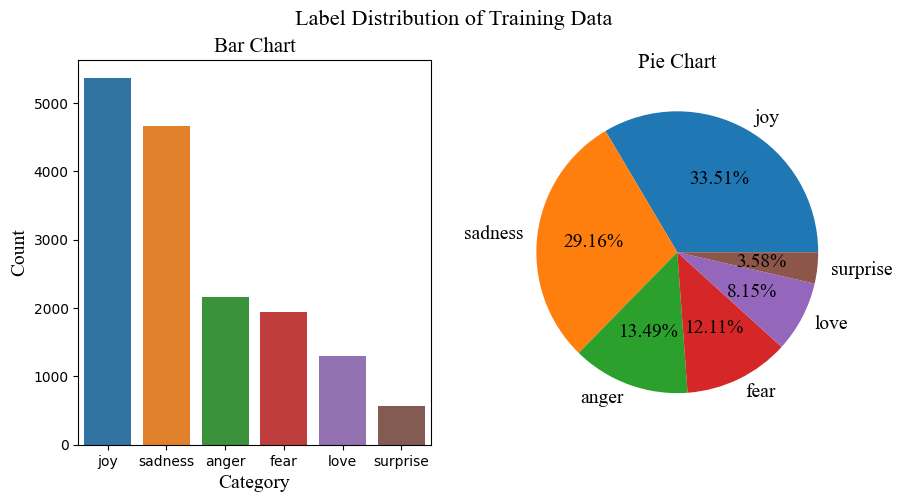

joy: 5362 (33.51%)
sadness: 4666 (29.16%)
anger: 2159 (13.49%)
fear: 1937 (12.11%)
love: 1304 (8.15%)
surprise: 572 (3.57%)


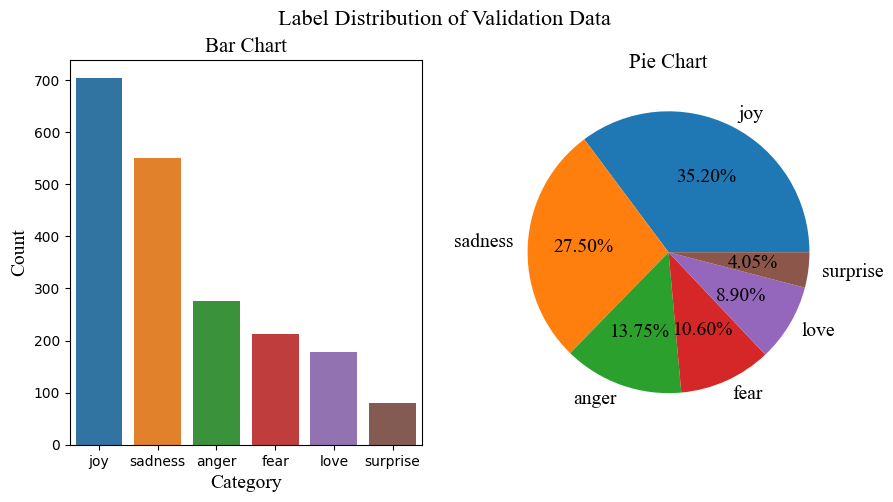

joy: 704 (35.20%)
sadness: 550 (27.50%)
anger: 275 (13.75%)
fear: 212 (10.60%)
love: 178 (8.90%)
surprise: 81 (4.05%)


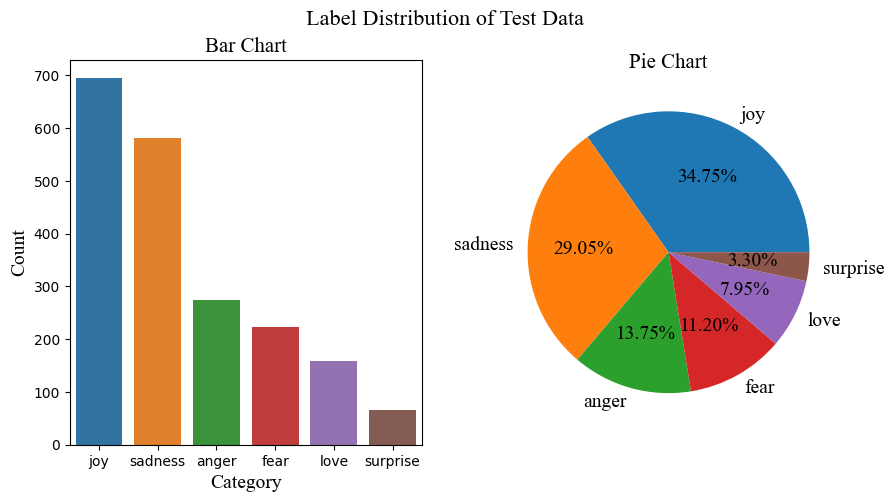

joy: 695 (34.75%)
sadness: 581 (29.05%)
anger: 275 (13.75%)
fear: 224 (11.20%)
love: 159 (7.95%)
surprise: 66 (3.30%)


In [6]:
# plot distribution of training, validation and test data
training_distribution = NLP.plot_distribution(training_df, 'description', 'Training')
training_distribution.savefig(os.path.join(save_path, '1 Label Distribution of Training Data.png'))

validation_distribution = NLP.plot_distribution(validation_df, 'description', 'Validation')
validation_distribution.savefig(os.path.join(save_path, '2 Label Distribution of Validation Data.png'))

test_distribution = NLP.plot_distribution(test_df, 'description', 'Test')
test_distribution.savefig(os.path.join(save_path, '3 Label Distribution of Test Data.png'))

In [7]:
# show training dataframe
training_df

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Data Pre-processing

In [8]:
# data clearning and get maximum length
print('Start data cleaning ...')
print('Remove all URL links https?:\/\/\S+', )
print('Removing all punctuation', string.punctuation)
print('Convert all letters to lowercase')
    
word2id, max_len = NLP.get_vocab(tqdm(training_df['text'].tolist() + validation_df['text'].tolist()))

Start data cleaning ...
Remove all URL links https?:\/\/\S+
Removing all punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Convert all letters to lowercase


100%|██████████| 18000/18000 [00:02<00:00, 7077.89it/s]


In [9]:
# data tokenization
print('Start data tokenization ...')
X_train = NLP.tokenization(word2id, training_df['text'].tolist(), max_len)
X_valid = NLP.tokenization(word2id, validation_df['text'].tolist(), max_len)

Start data tokenization ...


100%|██████████| 2000/2000 [00:00<00:00, 6802.19it/s]


In [10]:
# labels one hot encoding
onehot_encoder = OneHotEncoder(sparse_output = False)
y_train = onehot_encoder.fit_transform(np.array(training_df['label'].tolist()).reshape(-1, 1))
y_valid = onehot_encoder.fit_transform(np.array(validation_df['label'].tolist()).reshape(-1, 1)) 

print('The shape of training dataset is', X_train.shape)
print('The shape of validation dataset is', X_valid.shape)

print('\nThe shape of training label is', y_train.shape)
print('The shape of validation label is', y_valid.shape)

The shape of training dataset is (16000, 66)
The shape of validation dataset is (2000, 66)

The shape of training label is (16000, 6)
The shape of validation label is (2000, 6)


## Model Training

In [11]:
# build MLP model
model_MLP = models.Sequential()
model_MLP.add(layers.Embedding(input_dim = len(word2id), output_dim = 100, input_length = max_len))
model_MLP.add(layers.GlobalAveragePooling1D())
model_MLP.add(layers.Dense(128, activation = 'relu'))
model_MLP.add(layers.Dropout(0.2))
model_MLP.add(layers.Dense(6, activation = 'softmax'))
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1618900   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,632,602
Trainable params: 1,632,602
Non-trainable params: 0
______________________________________________

In [13]:
# compile model
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

model_MLP.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.Adam(0.001),
                  metrics = ['accuracy'])

In [14]:
# training model
start = time.time()
history_MLP = model_MLP.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 50, callbacks = callbacks)
end = time.time()

print('\nTime for training MLP model is: %.2f' %(end - start) + 's')

Epoch 1/50
500/500 [==============================] - 3s 4ms/step - loss: 1.5563 - accuracy: 0.3673 - val_loss: 1.4342 - val_accuracy: 0.5170
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 0.9338 - accuracy: 0.6817 - val_loss: 0.6532 - val_accuracy: 0.8275
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 0.3814 - accuracy: 0.8927 - val_loss: 0.4475 - val_accuracy: 0.8530
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 0.2086 - accuracy: 0.9374 - val_loss: 0.4078 - val_accuracy: 0.8670
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 0.1395 - accuracy: 0.9599 - val_loss: 0.4013 - val_accuracy: 0.8775
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 0.1041 - accuracy: 0.9692 - val_loss: 0.4091 - val_accuracy: 0.8785
Epoch 7/50
500/500 [==============================] - 2s 3ms/step - loss: 0.0815 - accuracy: 0.9766 - val_loss: 0.4203 - val_accuracy: 0.8845
Epoch 

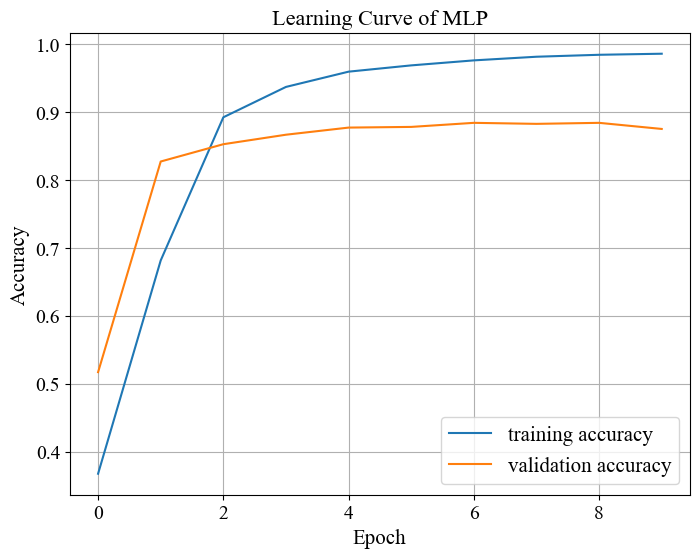

The Training Accuracy of MLP is 0.9864
The Validation Accuracy of MLP is 0.8755


In [15]:
# plot learning curve
learning_curve_MLP = NLP.plot_learning_curve(history_MLP, 'MLP')
learning_curve_MLP.savefig(os.path.join(save_path, '4 Learn Curve of MLP.png'))

## Model Evaluation

In [16]:
# prepare test data
print('Start data tokenization ...')
X_test = NLP.tokenization(word2id, test_df['text'].tolist(), max_len)
y_test = test_df['label'].tolist()

Start data tokenization ...


100%|██████████| 2000/2000 [00:00<00:00, 5000.88it/s]


In [17]:
# show the shape of test data and test label
print('The shape of validation dataset is', X_test.shape)
print('The length of training label is', len(y_test))

The shape of validation dataset is (2000, 66)
The length of training label is 2000


In [18]:
# evaludte test accuracy
y_pred_MLP = np.argmax(model_MLP.predict(X_test), axis = 1)
print('The Test accuracy of MLP is %.4f' %(accuracy_score(y_test, y_pred_MLP)))

63/63 [==============================] - 0s 1ms/step
The Test accuracy of MLP is 0.8735


Confusion Matrix of MLP:
          sadness  joy  love  anger  fear  surprise
sadness       537   20     1     13    10         0
joy            10  651    25      3     5         1
love            0   51   100      6     0         2
anger          25    7     0    232    11         0
fear           15    1     1      4   201         2
surprise        3    6     7      5    19        26

Classification Report of MLP:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       581
           1       0.88      0.94      0.91       695
           2       0.75      0.63      0.68       159
           3       0.88      0.84      0.86       275
           4       0.82      0.90      0.86       224
           5       0.84      0.39      0.54        66

    accuracy                           0.87      2000
   macro avg       0.85      0.77      0.79      2000
weighted avg       0.87      0.87      0.87      2000



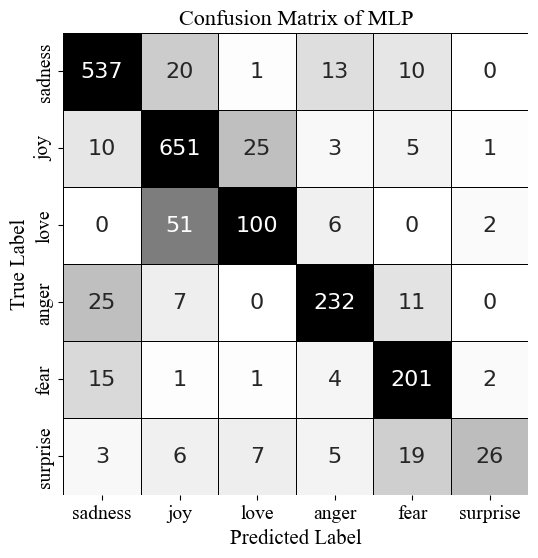

In [19]:
# plot confusion matrix
CM_MLP = pd.DataFrame(confusion_matrix(y_test, y_pred_MLP), index = category , columns = category)
print('Confusion Matrix of MLP:')
print(CM_MLP)

print('\nClassification Report of MLP:')
print(classification_report(y_test, y_pred_MLP))

MLP_confusion_matrix = NLP.plot_CM_matrix(CM_MLP, 'Confusion Matrix of MLP')
MLP_confusion_matrix.savefig(os.path.join(save_path, '5 Confusion Matrix of MLP.png'))

In [20]:
# save results
test_df['pred_MLP'] = y_pred_MLP
test_df['pred_MLP_discription'] = test_df['pred_MLP'].map(labels_dict)
test_df.to_csv(os.path.join(save_path, 'result_B.csv'))